In [1]:

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def load_data(data_dir):
    categories = ['Cloudy', 'fogsmog', 'lightning', 'rain', 'rainbow', 'sandstorm', 'Shine', 'snow', 'Sunrise']
    data = []
    labels = []
    
    for category in categories:
        path = os.path.join(data_dir, category)
        class_num = categories.index(category)
        count = 0  # Counter for successfully loaded images
        
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                if img_array is not None:
                    data.append(img_array)
                    labels.append(class_num)
                    count += 1
            except Exception as e:
                print(f"Error reading image {img} in category '{category}': {e}")
                pass
        
        print(f"[{category}] -> Loaded {count} images.")
    
    return data, labels

def preprocess_images(images):
    resized_images = [cv2.resize(img, (32, 32)) for img in images]
    flattened_images = [img.flatten() for img in resized_images]
    return np.array(flattened_images)

# Load data
data_dir = 'F:/Data Mining Project/dataset'  # Single directory containing all category subdirectories
X, y = load_data(data_dir)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_flat = preprocess_images(X_train)

X_test_flat = preprocess_images(X_test)


[Cloudy] -> Loaded 300 images.
[fogsmog] -> Loaded 429 images.
[lightning] -> Loaded 377 images.
[rain] -> Loaded 429 images.
[rainbow] -> Loaded 232 images.
[sandstorm] -> Loaded 396 images.
[Shine] -> Loaded 252 images.
[snow] -> Loaded 362 images.
[Sunrise] -> Loaded 357 images.


In [2]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)


In [3]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


In [4]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

# Create SVM model (using RBF kernel by default)
svm_model = SVC(kernel='rbf', C=1, gamma='scale', random_state=42)

# Train on training PCA features
svm_model.fit(X_train_pca, y_train)

# Predict on test PCA features
y_pred_svm = svm_model.predict(X_test_pca)

# Evaluate results
accuracy_svm = accuracy_score(y_test, y_pred_svm)
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
macro_f1_svm = f1_score(y_test, y_pred_svm, average='macro')

print("SVM Accuracy:", accuracy_svm)
print("SVM Confusion Matrix:\n", conf_matrix_svm)
print("SVM Macro F1 Score:", macro_f1_svm)


SVM Accuracy: 0.7017543859649122
SVM Confusion Matrix:
 [[35 10 11  7  4  0  7  0  0]
 [ 5 72  3  7  1  3  2  2  0]
 [ 4  2 52  4  0  0  1  0  0]
 [ 1  5  5 62  1  2  0 10  1]
 [ 5  8  6  3 17  2  5  0  1]
 [ 1  9  0  3  1 60  0  0  4]
 [ 1  1  2  0  0  0 39  3  0]
 [ 0  9  0 14  2  1  1 44  0]
 [ 0  0  1  1  0  4  1  0 59]]
SVM Macro F1 Score: 0.6925569942890968


In [7]:
import matplotlib.pyplot as plt
import cv2

def show_image_prediction(idx, model, original_images, true_labels, scaler=None, pca=None):
    categories = ['Cloudy', 'fogsmog', 'lightning', 'rain', 'rainbow', 'sandstorm', 'Shine', 'snow', 'Sunrise']
    
    # Get the original image and true label
    specific_image = original_images[idx]
    actual_class = categories[int(true_labels[idx])]
    
    # Flatten, scale, and apply PCA if needed
    img_flat = cv2.resize(specific_image, (32, 32)).flatten().reshape(1, -1)
    if scaler:
        img_flat = scaler.transform(img_flat)
    if pca:
        img_flat = pca.transform(img_flat)
    
    # Predict class
    predicted_class = categories[int(model.predict(img_flat)[0])]
    
    # Display image with actual and predicted label
    plt.figure(figsize=(4, 4))
    plt.imshow(cv2.cvtColor(specific_image, cv2.COLOR_BGR2RGB))
    plt.title(f"Index {idx}\nActual: {actual_class} | Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()


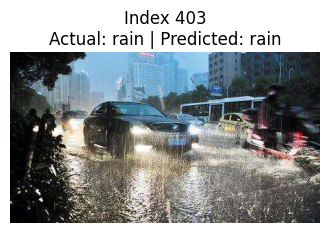

In [42]:
import random

random_index = random.randint(0, len(X_test) - 1)
show_image_prediction(random_index, svm_model, X_test, y_test, scaler=scaler, pca=pca)


In [112]:
def predict_external_image(image_path, model, scaler=None, pca=None):
    categories = ['Cloudy', 'fogsmog', 'lightning', 'rain', 'rainbow', 'sandstorm', 'Shine', 'snow', 'Sunrise']
    
    # Load the external image
    img = cv2.imread(image_path)
    if img is None:
        print("Error: Unable to read the image.")
        return
    
    # Resize and preprocess
    img_resized = cv2.resize(img, (32, 32))
    img_flat = img_resized.flatten().reshape(1, -1)
    
    # Apply same scaling and PCA as training
    if scaler:
        img_flat = scaler.transform(img_flat)
    if pca:
        img_flat = pca.transform(img_flat)
    
    # Predict class
    predicted_class = categories[int(model.predict(img_flat)[0])]
    
    # Display
    plt.figure(figsize=(4, 4))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()


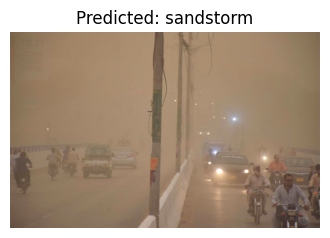

In [123]:
predict_external_image("F:/Data Mining Project/1.jpg", svm_model, scaler=scaler, pca=pca)